In [1]:
import time
import scipy.io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from scipy.optimize import minimize
import pickle
from matplotlib.table import Table
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.random.set_seed(1234)

2023-05-05 03:19:30.633335: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 03:19:30.636101: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 03:19:30.675519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 03:19:30.676333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 03:19:31.319352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class TensorPINN:
    def __init__(self, X_u, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.X_u = X_u
        self.u = u
        
        self.layers = layers
        
        # Initialize NN weights and biases
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Define optimizer
        self.optimizer = tf.keras.optimizers.Adam()
        
        # Define TensorFlow tensors and graphs
        self.tf_X_u = tf.constant(self.X_u, dtype=tf.float32)
        self.tf_u = tf.constant(self.u, dtype=tf.float32)
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        # Define the physics-informed neural network
        self.net_u = tf.function(self.net_u)
        self.net_f = tf.function(self.net_f)
        self.loss = tf.function(self.loss)
        
        # Define empty lists to store losses and lambdas
        self.loss_history = []
        self.u_loss_history = []
        self.f_loss_history = []
        self.lambda_1_history = []
        self.lambda_2_history = []
        
    
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1, layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    # Define NN architecture
    def neural_net(self, X):
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0, len(self.layers)-2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.math.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, x, t):
        X = tf.concat([x, t], 1)
        u = self.neural_net(X)
        return u
    
    def net_f(self, x, t):
        # Define the PDE
        X = tf.concat([x, t],1)
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X)
            u = self.neural_net(X)
            u_x = tape.gradient(u, X)[:, 0:1]
            u_t = tape.gradient(u, X)[:, 1:2]
        u_xx = tape.gradient(u_x, X)[:, 0:1]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    # Calculating losses
    def loss(self):
        X_u_tf = self.tf_X_u[:, 0:1]
        t_u_tf = self.tf_X_u[:, 1:2]
        u_tf = self.tf_u
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X_u_tf)
            tape.watch(t_u_tf)
            u_pred = self.net_u(X_u_tf, t_u_tf)
            f_pred = self.net_f(X_u_tf, t_u_tf)
        loss_u = tf.reduce_mean(tf.square(u_tf - u_pred))
        loss_f = tf.reduce_mean(tf.square(f_pred))
        loss = loss_u + loss_f
        return loss, loss_u, loss_f

    def train(self, num_epochs):
        
        self.loss_history = []
        self.u_loss_history = []
        self.f_loss_history = []
        self.lambda_1_history = []
        self.lambda_2_history = []
        
        for epoch in range(num_epochs):
            # Optimize the loss
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(self.weights + self.biases + [self.lambda_1, self.lambda_2])
                current_loss, loss_u, loss_f = self.loss()
                
                self.u_loss_history.append(loss_u.numpy())
                self.f_loss_history.append(loss_f.numpy())
                
            # Compute gradients
            gradients = tape.gradient(current_loss, self.weights + self.biases + [self.lambda_1, self.lambda_2])

            # Update weights, biases, and lambdas
            self.optimizer.apply_gradients(zip(gradients, self.weights + self.biases + [self.lambda_1, self.lambda_2]))

            current_loss_value = current_loss.numpy()
            lambda_1_value = self.lambda_1.numpy()
            lambda_2_value = tf.math.exp(self.lambda_2).numpy()
            
            self.loss_history.append(current_loss_value)
            self.lambda_1_history.append(lambda_1_value)
            self.lambda_2_history.append(lambda_2_value[0])
            
            # Print the current loss
            if epoch % 100 == 0:
                
                print(f"Loss: {current_loss_value}, l1: {lambda_1_value}, l2: {lambda_2_value[0]}")
                
    def predict(self, X_star):
        
        X_star = tf.constant(X_star, dtype=tf.float32)
        
        x_star = X_star[:, 0:1]
        t_star = X_star[:, 1:2]

        u_star = self.net_u(x_star, t_star)
        f_star = self.net_f(x_star, t_star)
        
        u_star = u_star.numpy()
        f_star = f_star.numpy()

        return u_star, f_star

In [4]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

noise = 0.0            
            
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

In [5]:
# Initialize model
model = TensorPINN(X_u_train, u_train, layers, lb, ub)
model.train(6000)

2023-05-05 03:19:59.098253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_1_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradients/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_1_grad/StridedSliceGrad/strides}}]]
2023-05-05 03:19:59.099970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [

Loss: 0.3534345030784607, l1: [-0.00053063], l2: 0.0024789590388536453
Loss: 0.041373856365680695, l1: [0.04963053], l2: 0.0023448443971574306
Loss: 0.031760748475790024, l1: [0.0783358], l2: 0.002369512338191271
Loss: 0.025569267570972443, l1: [0.13973787], l2: 0.002358442870900035
Loss: 0.02241661585867405, l1: [0.19674529], l2: 0.0023251737002283335
Loss: 0.01905883476138115, l1: [0.25067976], l2: 0.0023286810610443354
Loss: 0.016615958884358406, l1: [0.30570886], l2: 0.002369905589148402
Loss: 0.01505616307258606, l1: [0.35943034], l2: 0.0024302315432578325
Loss: 0.01277083344757557, l1: [0.40385363], l2: 0.002478222828358412
Loss: 0.011696849949657917, l1: [0.45168808], l2: 0.002521939342841506
Loss: 0.009635998867452145, l1: [0.47594908], l2: 0.0025488873943686485
Loss: 0.009608620777726173, l1: [0.51017636], l2: 0.0025771516375243664
Loss: 0.008202772587537766, l1: [0.5337598], l2: 0.002606505760923028
Loss: 0.00827784650027752, l1: [0.53014153], l2: 0.002630103612318635
Loss: 0

In [6]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.numpy()
lambda_2_value = model.lambda_2.numpy()

lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1.item():.5f}%')
print(f'Error l2: {error_lambda_2.item():.5f}%')

Error u: 4.2e-02
Error l1: 14.51715%
Error l2: 3.81716%


Text(0.5, 0.98, 'Model performance')

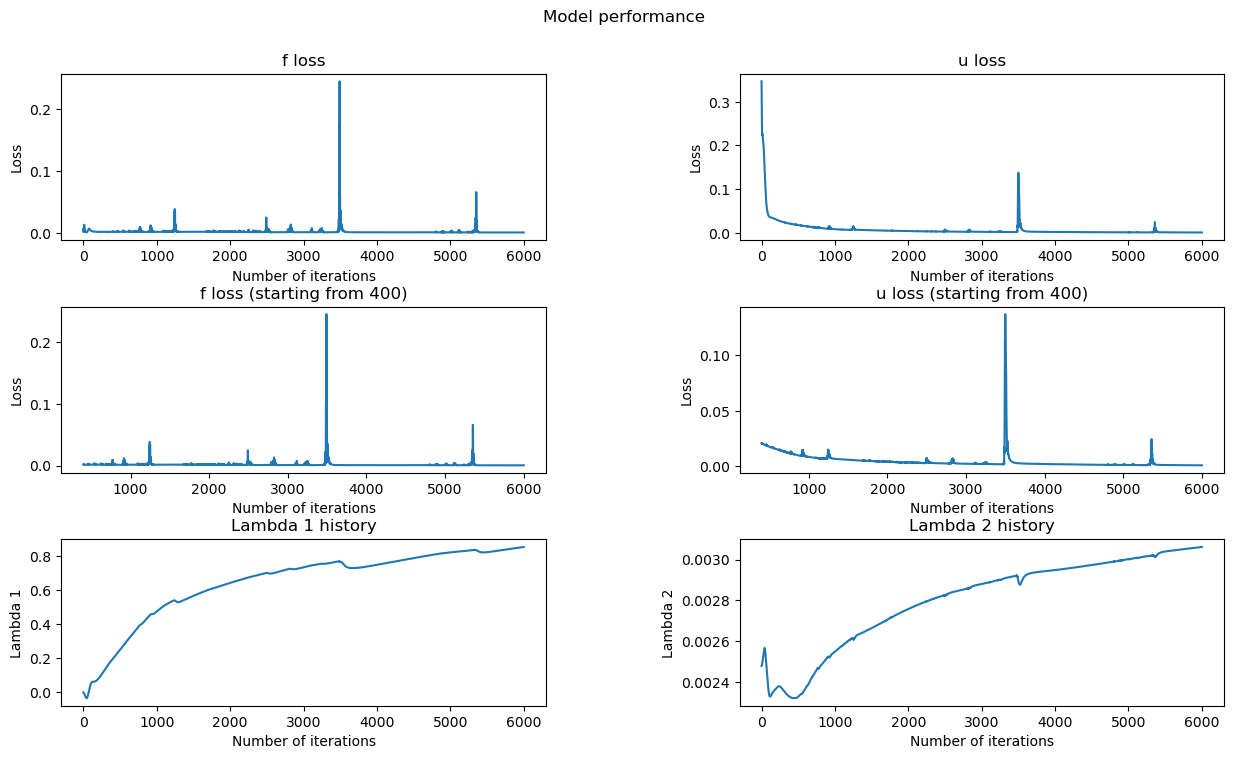

In [7]:
skip_size = 400
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history)), model.f_loss_history, label="f loss")
axs[0,0].set_xlabel('Number of iterations')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("f loss")

axs[0,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history)), model.u_loss_history, label="u loss")
axs[0,1].set_xlabel('Number of iterations')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title("u loss")

axs[1,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history))[skip_size:], model.f_loss_history[skip_size:], label="f loss")
axs[1,0].set_xlabel('Number of iterations')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_title(f"f loss (starting from {skip_size})")

axs[1,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history))[skip_size:], model.u_loss_history[skip_size:], label="u loss")
axs[1,1].set_xlabel('Number of iterations')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title(f"u loss (starting from {skip_size})")

axs[2,0].plot(np.linspace(0, len(model.lambda_1_history), len(model.lambda_1_history)), model.lambda_1_history, label="lambda 1")
axs[2,0].set_xlabel('Number of iterations')
axs[2,0].set_ylabel('Lambda 1')
axs[2,0].set_title("Lambda 1 history")

axs[2,1].plot(np.linspace(0, len(model.lambda_2_history), len(model.lambda_2_history)), model.lambda_2_history, label="lambda 2")
axs[2,1].set_xlabel('Number of iterations')
axs[2,1].set_ylabel('Lambda 2')
axs[2,1].set_title("Lambda 2 history")

fig.suptitle("Model performance")

In [8]:
noise = 0.01

# Create training set with noise
u_train = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])

# Training with noisy data
model = TensorPINN(X_u_train, u_train, layers, lb, ub)
model.train(10000)

2023-05-05 03:27:20.062734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_1_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradients/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_1_grad/StridedSliceGrad/strides}}]]
2023-05-05 03:27:20.064654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/strided_slice_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [

Loss: 0.41358450055122375, l1: [0.0007882], l2: 0.0024784603156149387
Loss: 0.08998134732246399, l1: [-0.05181067], l2: 0.0025868311058729887
Loss: 0.03735356032848358, l1: [0.05368932], l2: 0.0023528356105089188
Loss: 0.0319385901093483, l1: [0.07260875], l2: 0.0024015565868467093
Loss: 0.0271633118391037, l1: [0.11996632], l2: 0.0024556724820286036
Loss: 0.024389144033193588, l1: [0.17033166], l2: 0.002480744617059827
Loss: 0.0225625392049551, l1: [0.21225984], l2: 0.002524307230487466
Loss: 0.020636888220906258, l1: [0.25382838], l2: 0.0025823672767728567
Loss: 0.01853489689528942, l1: [0.2956572], l2: 0.0026148115284740925
Loss: 0.0159946009516716, l1: [0.3431336], l2: 0.0026342079509049654
Loss: 0.014503256417810917, l1: [0.3993998], l2: 0.0026716338470578194
Loss: 0.013784096576273441, l1: [0.445565], l2: 0.002721028169617057
Loss: 0.010620418936014175, l1: [0.479772], l2: 0.002775150816887617
Loss: 0.00936112180352211, l1: [0.49087256], l2: 0.002797030145302415
Loss: 0.008437271

In [9]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.numpy()
lambda_2_value = model.lambda_2.numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1.item():.5f}%')
print(f'Error l2: {error_lambda_2.item():.5f}%')

Error u: 2.2e-02
Error l1: 7.21555%
Error l2: 5.46278%


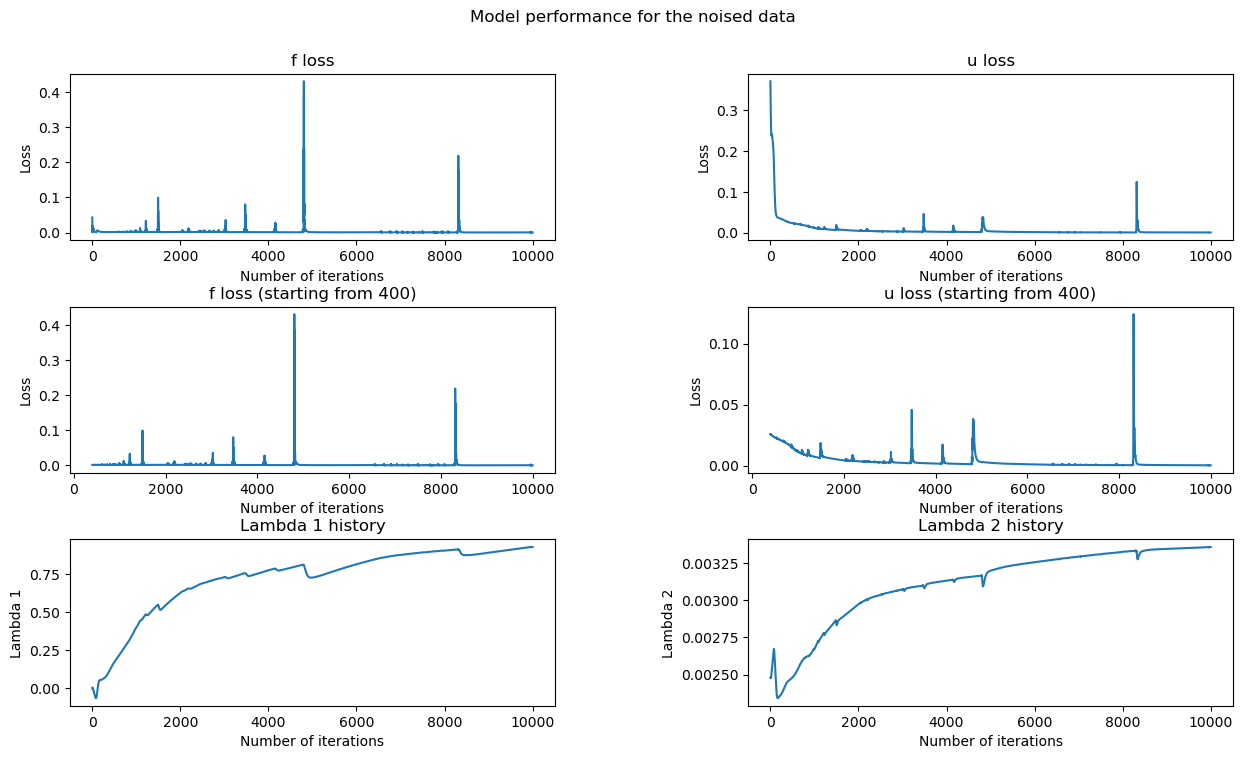

In [10]:
skip_size = 400
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history)), model.f_loss_history, label="f loss")
axs[0,0].set_xlabel('Number of iterations')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("f loss")

axs[0,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history)), model.u_loss_history, label="u loss")
axs[0,1].set_xlabel('Number of iterations')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title("u loss")

axs[1,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history))[skip_size:], model.f_loss_history[skip_size:], label="f loss")
axs[1,0].set_xlabel('Number of iterations')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_title(f"f loss (starting from {skip_size})")

axs[1,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history))[skip_size:], model.u_loss_history[skip_size:], label="u loss")
axs[1,1].set_xlabel('Number of iterations')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title(f"u loss (starting from {skip_size})")

axs[2,0].plot(np.linspace(0, len(model.lambda_1_history), len(model.lambda_1_history)), model.lambda_1_history, label="lambda 1")
axs[2,0].set_xlabel('Number of iterations')
axs[2,0].set_ylabel('Lambda 1')
axs[2,0].set_title("Lambda 1 history")

axs[2,1].plot(np.linspace(0, len(model.lambda_2_history), len(model.lambda_2_history)), model.lambda_2_history, label="lambda 2")
axs[2,1].set_xlabel('Number of iterations')
axs[2,1].set_ylabel('Lambda 2')
axs[2,1].set_title("Lambda 2 history")

fig.suptitle("Model performance for the noised data")
plt.show()

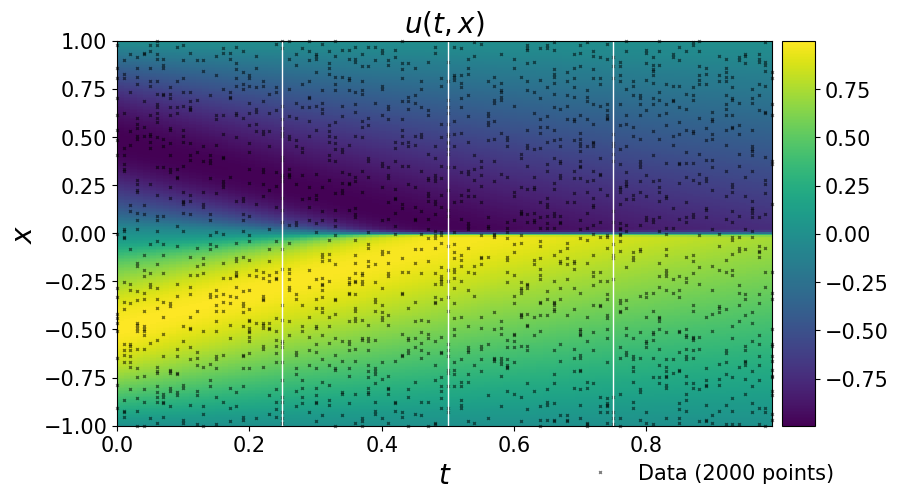

In [11]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    X_u_train[:, 1],
    X_u_train[:, 0],
    'kx', label=f'Data ({u_train.shape[0]} points)',
    markersize=2,
    clip_on=False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize=20)
ax.tick_params(labelsize=15)

plt.show()


In [68]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

/tmp/ipykernel_38091/2857511912.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, Exact[t_values[i], :], 'b-', linewidth=2, label='Exact', color="green")
/tmp/ipykernel_38091/2857511912.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, U_pred[t_values[i], :], 'r--', linewidth=2, label='Prediction', color="purple")


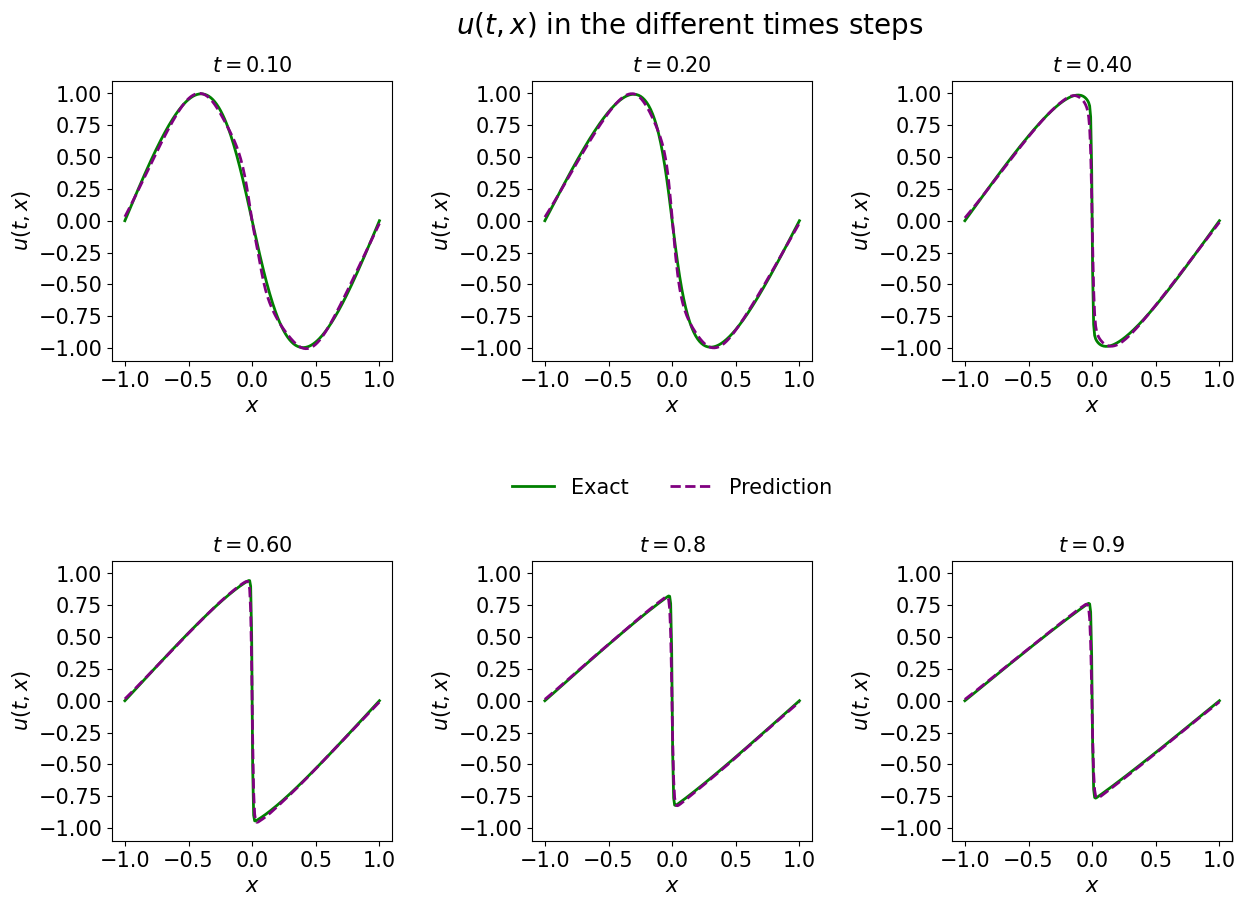

In [69]:
fig = plt.figure(figsize=(14, 10))

gs1 = gridspec.GridSpec(2, 3)
gs1.update(top=1 - 0.1, bottom=0.1, left=0.1, right=0.9, wspace=0.5, hspace=0.5)

t_values = [10, 20, 40, 60, 80, 90]
titles = ['$t = 0.10$', '$t = 0.20$', '$t = 0.40$', '$t = 0.60$', '$t = 0.8$', '$t = 0.9$']

for i in range(6):
    row = i // 3
    col = i % 3
    ax = plt.subplot(gs1[row, col])
    ax.plot(x, Exact[t_values[i], :], 'b-', linewidth=2, label='Exact', color="green")
    ax.plot(x, U_pred[t_values[i], :], 'r--', linewidth=2, label='Prediction', color="purple")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title(titles[i], fontsize=15)

    if i == 1:
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, -0.35),
            ncol=5,
            frameon=False,
            prop={'size': 15}
        )

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

big_title_ax = fig.add_subplot(111, frame_on=False)
big_title_ax.set_axis_off()
big_title_ax.set_title('$u(t,x)$ in the different times steps', fontsize=20, y=1.05)

plt.show()

In [76]:
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.numpy()
lambda_2_value_noisy = model.lambda_2.numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1_noisy.item():.5f}%')
print(f'Error l2: {error_lambda_2_noisy.item():.5f}%')

Error u: 4.6e-02
Error l1: 4.74716%
Error l2: 79.78139%


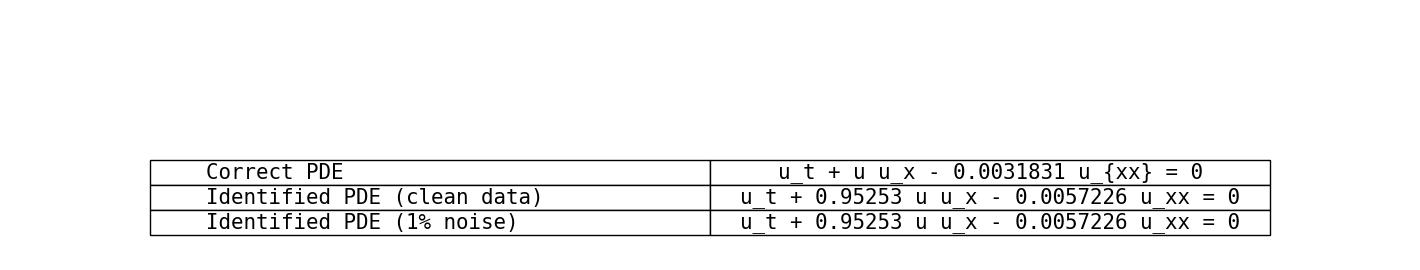

In [79]:
fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 1)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

xx = 'xx'

# Table data
table_data = [
    ['Correct PDE', 'u_t + u u_x - 0.0031831 u_{xx} = 0'],
    ['Identified PDE (clean data)', f'u_t + {lambda_1_value.item():.5f} u u_x - {lambda_2_value.item():.7f} u_{xx} = 0'],
    ['Identified PDE (1% noise)', f'u_t + {lambda_1_value_noisy.item():.5f} u u_x - {lambda_2_value_noisy.item():.7f} u_{xx} = 0'],
]

# Draw the table
table = Table(ax, bbox=[0.1, 0.1, 0.8, 0.3])

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell_text in enumerate(row):
        table.add_cell(i, j, width=0.9, height=0.8,
                       text=cell_text, loc='left' if j == 0 else 'center',
                       fontproperties={'size': 18, 'family': 'monospace'})

# Set column and row labels
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1, 2.5)

# Add table to the figure
ax.add_table(table)
